In [1]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterio.features import shapes
from rasterio.mask import mask as rio_mask
from shapely.geometry import mapping
from shapely.geometry import box
from shapely.geometry import shape
from shapely.validation import explain_validity
import matplotlib.pyplot as plt
from tqdm import tqdm
from osgeo import gdal
import yaml
import os

# Load configuration
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

##### Trim Raster to a Reasonable size

Original CRS: EPSG:4326
Clipped raster saved successfully.
EPSG:4326


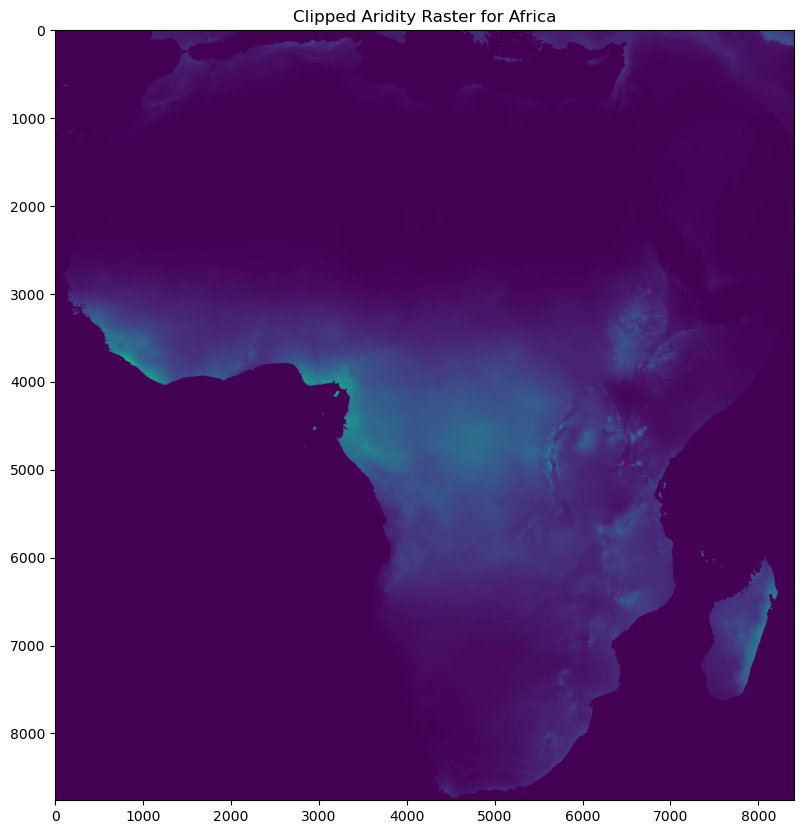

In [3]:
# Load configuration
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

# Load the raster file and define the bounding box for Africa
with rasterio.open(resolve_path(config['Global_Aridity_Raster_path'])) as src:
    print(f"Original CRS: {src.crs}")

    # Define the bounding box for Africa (in degrees)
    minx, miny = -18.0, -35.0  # approximate coordinates for Africa
    maxx, maxy = 52.0, 38.0

    # Create a bounding box polygon
    bbox = box(minx, miny, maxx, maxy)
    bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox]}, index=[0], crs=src.crs)

    # Clip the raster to the bounding box
    out_image, out_transform = mask(src, bbox_gdf.geometry, crop=True)
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    # Save the clipped raster
    clipped_tif_path = resolve_path(config['Africa_Arid_Regions_tif_path'])
    #with rasterio.open(clipped_tif_path, "w", **out_meta) as dest:
        #dest.write(out_image)

    
    print("Clipped raster saved successfully.")

# Load and visualize the clipped raster to ensure it's correct
with rasterio.open(clipped_tif_path) as src:
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(src.read(1), cmap='viridis')
    ax.set_title("Clipped Aridity Raster for Africa")
    plt.show()

##### Get continent outline from Africa_Boundaries

Loading Africa boundaries shapefile...
Adding dummy column for dissolving...
Dissolving boundaries to get single outline of the continent...
Setting CRS for dissolved outline...
Plotting the continent outline to verify...


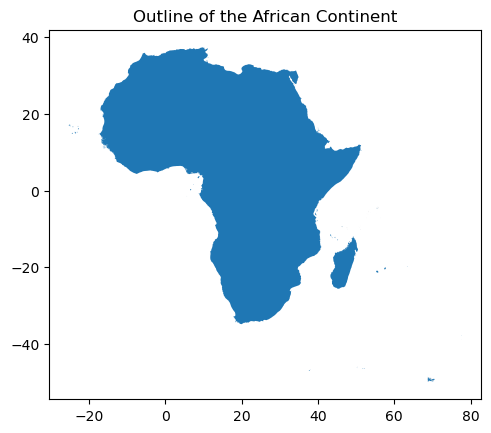

In [5]:
# Load the Africa boundaries shapefile
print("Loading Africa boundaries shapefile...")
africa_boundaries_path = resolve_path(config['Africa_boundaries_shp_path'])
africa_gdf = gpd.read_file(africa_boundaries_path)

# Add a dummy column for dissolving
print("Adding dummy column for dissolving...")
africa_gdf['continent'] = 'Africa'

# Dissolve the boundaries to get a single outline for the continent
print("Dissolving boundaries to get single outline of the continent...")
africa_continent = africa_gdf.dissolve(by='continent')

# Set the CRS of the dissolved outline to EPSG:4326
print("Setting CRS for dissolved outline...")
africa_continent.set_crs(epsg=4326, inplace=True)
africa_continent.to_file(resolve_path(config['Africa_Continent_shp_path']))

# Plot the continent outline to verify
print("Plotting the continent outline to verify...")
africa_continent.plot()
plt.title('Outline of the African Continent')
plt.show()

##### Trim the .tif file

In [7]:
from rasterio.mask import mask as rio_mask
from shapely.geometry import mapping

raster = rasterio.open(resolve_path(config['Africa_Arid_Regions_tif_path']))

for i, feature in africa_continent.iterrows():
    geometry = [mapping(feature.geometry)]
    
    # Trim the raster using the shapefile's geometry
    out_image, out_transform = rio_mask(raster, geometry, crop=True)
    out_meta = raster.meta.copy()

    # Update the metadata of the output raster
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

print(raster.crs)
#with rasterio.open(resolve_path(config['Africa_Arid_Regions_tif_path2']), "w", **out_meta) as dest:
    #dest.write(out_image)


EPSG:4326


##### Make it a Shapefile

Number of geometries for /home/ermiller/Africa_Irrigation/Data/Processed/Africa_Hyper_Arid-shp: 1833


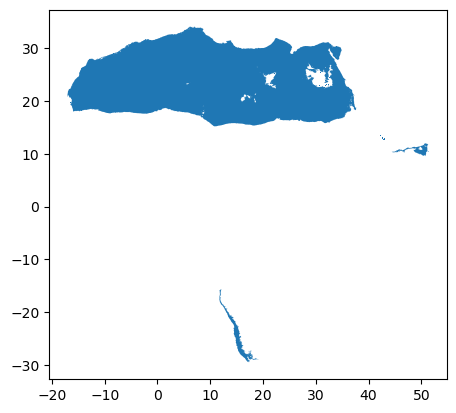

CRS for hyper_arid is not set correctly!
Number of geometries for /home/ermiller/Africa_Irrigation/Data/Processed/Africa_Semi_Arid-shp: 4622


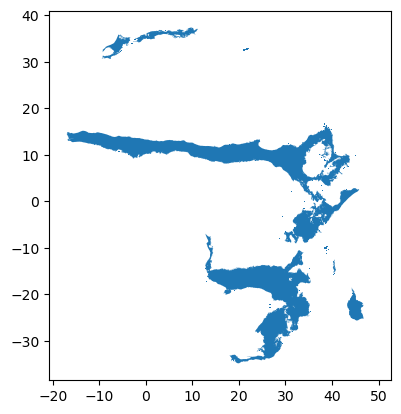

CRS for semi_arid: EPSG:4326
Number of geometries for /home/ermiller/Africa_Irrigation/Data/Processed/Africa_Arid-shp: 3181


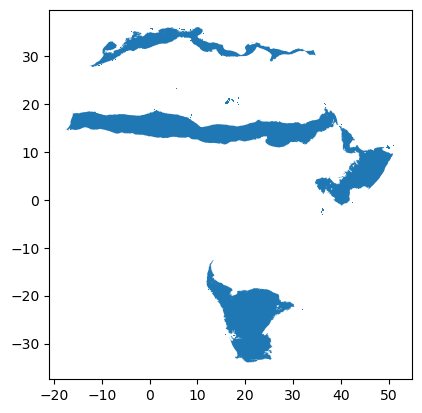

CRS for arid: EPSG:4326
Number of geometries for /home/ermiller/Africa_Irrigation/Data/Processed/Africa_Arid_Regions_All-shp: 3567


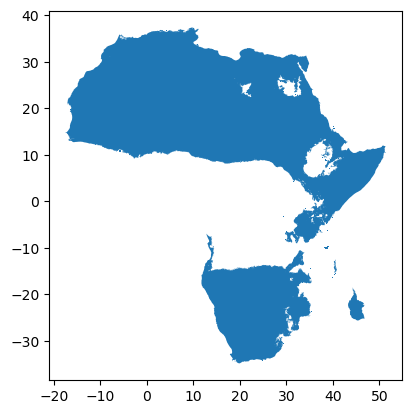

CRS for all: EPSG:4326


In [28]:
# Load the .tif file
tif_path = resolve_path(config['Africa_Arid_Regions_tif_path2'])
with rasterio.open(tif_path) as src:
    data = src.read(1)
    profile = src.profile

# Replace NaN values with 0
data = np.nan_to_num(data, nan=0)

# Mask out data greater than 5000 (data > 5000 set to 0)
data_masked = np.where(data > 5000, 0, data)

# Define aridity levels
arid_classes = {
    'hyper_arid': (1, 299),
    'semi_arid': (2001, 5000),
    'arid': (300, 2000)
    
    #'all': (1, 5000)
}

# Create a mask for each aridity level
masks = {key: np.where((data_masked > val[0]) & (data_masked <= val[1]), 1, 0) for key, val in arid_classes.items()}

# Create a mask for all data within the aridity range 
masks['all'] = np.where(data_masked > 0, 1, 0)  # Mask for all data (0 < x <= 5000)

from shapely.validation import explain_validity

def create_shapefile(mask, profile, output_path):
    # Convert mask to uint8
    mask_uint8 = mask.astype('uint8')
    
    # Extract shapes
    shapes_gen = shapes(mask_uint8, transform=profile['transform'])
    geoms = [shape(geom) for geom, value in shapes_gen if value == 1]
    
    # Check for invalid geometries
    for i, geom in enumerate(geoms):
        if not geom.is_valid:
            print(f"Invalid geometry at index {i}: {explain_validity(geom)}")

    # Print number of geometries for debugging
    print(f"Number of geometries for {output_path}: {len(geoms)}")

    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=geoms)
    gdf.crs = "EPSG:4326"  # Set the CRS
    
    # Explicitly force CRS transformation
    gdf = gdf.to_crs("EPSG:4326")  # Transform to the same CRS
    
    # Save to shapefile
    gdf.to_file(output_path)

    # Plot for verification
    gdf.plot()
    plt.show()

# Run the code for each mask
for key, mask in masks.items():
    output_path = resolve_path(config[f'Africa_{key}_shp_path'])
    create_shapefile(mask, profile, output_path)

    # Verify the CRS
    gdf = gpd.read_file(output_path)
    if gdf.crs is None:
        print(f"CRS for {key} is not set correctly!")
    else:
        print(f"CRS for {key}: {gdf.crs}")


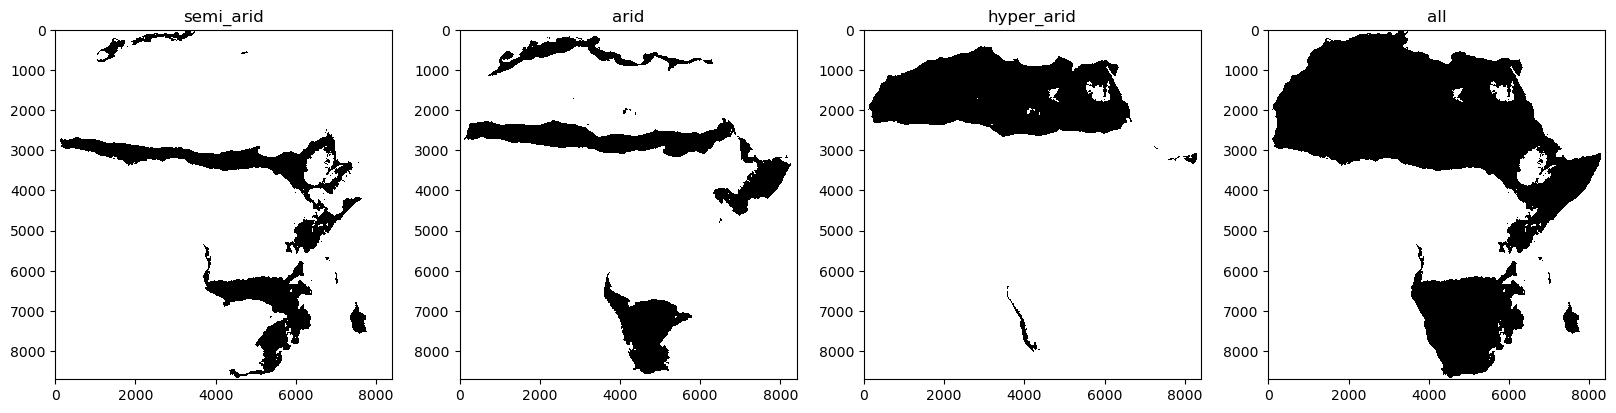

In [6]:
from matplotlib.colors import ListedColormap, BoundaryNorm

cmap = ListedColormap(['white', 'black'])
norm = BoundaryNorm([0, 0.5, 1], cmap.N)

# Plot masks
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, (key, mask) in enumerate(masks.items()):
    masked_array = np.ma.masked_invalid(mask)
    axes[i].imshow(masked_array, cmap=cmap, norm=norm)
    axes[i].set_title(key)
plt.show()

#### Code to merge the aridity layers and keep data:

In [ ]:
import geopandas as gpd
import pandas as pd
import os
import yaml

# Load configuration
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

# Define the aridity classes and corresponding shapefile paths
arid_classes = {
    'semi_arid': resolve_path(config['Africa_semi_arid_shp_path']),
    'arid': resolve_path(config['Africa_arid_shp_path']),
    'hyper_arid': resolve_path(config['Africa_hyper_arid_shp_path'])
}

# List to hold the GeoDataFrames
gdfs = []

# Read each shapefile, add the aridity class, and append to the list
for aridity, path in arid_classes.items():
    print(f"Loading {aridity} shapefile from {path}")
    gdf = gpd.read_file(path)
    gdf['aridity_class'] = aridity
    gdfs.append(gdf)

# Concatenate all GeoDataFrames
#combined_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

# Save the combined GeoDataFrame as a new shapefile
combined_shp_path = resolve_path(config['Africa_arid_layered_shp_path'])
#combined_gdf.to_file(combined_shp_path)

print(f"Combined shapefile saved successfully to {combined_shp_path}")


Loading semi_arid shapefile from /home/ermiller/Africa_Irrigation/Data/Processed/Africa_Semi_Arid-shp
Loading arid shapefile from /home/ermiller/Africa_Irrigation/Data/Processed/Africa_Arid-shp
Loading hyper_arid shapefile from /home/ermiller/Africa_Irrigation/Data/Processed/Africa_Hyper_Arid-shp


/tmp/ipykernel_220161/2663211947.py:36: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  combined_gdf.to_file(combined_shp_path)


Combined shapefile saved successfully to /home/ermiller/Africa_Irrigation/Data/Processed/Africa_Layered_Aridity-shp


/home/ermiller/miniconda3/envs/irrigation/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


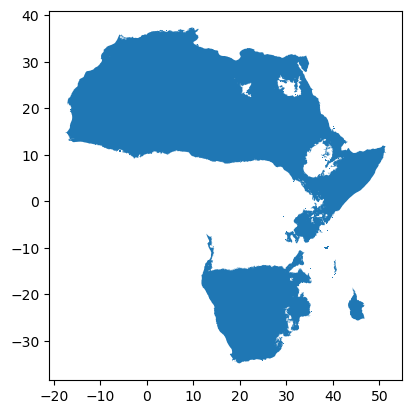

/tmp/ipykernel_290757/1411051182.py:11: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  merged_gdf.to_file(resolve_path(config['Africa_Arid_by_Country_shp_path']))


In [19]:
africa_arid = gpd.read_file(resolve_path(config['Africa_all_shp_path']))

africa_arid.set_crs(epsg=4326, inplace=True)
africa_gdf.set_crs(epsg=4326, inplace=True)

merged_gdf = gpd.sjoin(africa_arid, africa_gdf, how = 'inner', op = 'intersects')

merged_gdf.plot()
plt.show()

merged_gdf.to_file(resolve_path(config['Africa_Arid_by_Country_shp_path']))